In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [14]:
template_path = "template/pattern.png"
image_path = 'images/coca_multi.png'

template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_color = cv2.imread(image_path)

In [15]:
def preprocess_image(image):
    """aplica preprocesamiento a la imagen para mejorar la deteccion."""
    # normalizamos la imagen
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    
    # reducimos el ruido
    image = cv2.bilateralFilter(image, 9, 75, 75)  

    # detectamos los bordes
    edges = cv2.Canny(image, 50, 150)  

    return edges

processed_image = preprocess_image(image)

In [ ]:
def non_max_suppression_fast(boxes, scores, overlap_thresh=0.95):
    """Applicación de Non-Maximum Suppression (NMS) para eliminar bounding boxes solapados."""
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    scores = np.array(scores)
    # coordenadas de las bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    #Ordenamos por score
    order = scores.argsort()[::-1]

    picked_indices = []
    while len(order) > 0:
        i = order[0]  
        picked_indices.append(i)

        # Computamos el IoU (Intersection over Union)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        
        remaining_indices = np.where(iou <= overlap_thresh)[0]
        order = order[remaining_indices + 1]

    return picked_indices

Aplicando non max supresion para limitar la cantidad de rectangulos...
Bounding box 1 en coordenadas: (437, 149) a (537, 192)
Bounding box 2 en coordenadas: (399, 429) a (499, 472)
Bounding box 3 en coordenadas: (270, 145) a (370, 188)
Bounding box 4 en coordenadas: (142, 426) a (242, 469)
Bounding box 5 en coordenadas: (228, 428) a (328, 471)
Bounding box 6 en coordenadas: (103, 149) a (203, 192)
Bounding box 7 en coordenadas: (539, 150) a (639, 193)
Bounding box 8 en coordenadas: (557, 427) a (657, 470)
Bounding box 9 en coordenadas: (23, 146) a (123, 189)
Bounding box 10 en coordenadas: (623, 147) a (723, 190)
Bounding box 11 en coordenadas: (300, 429) a (400, 472)
Bounding box 12 en coordenadas: (66, 421) a (166, 464)
Bounding box 13 en coordenadas: (195, 149) a (295, 192)
Bounding box 14 en coordenadas: (481, 422) a (581, 465)
Bounding box 15 en coordenadas: (651, 423) a (751, 466)
Bounding box 16 en coordenadas: (362, 144) a (462, 187)
Bounding box 17 en coordenadas: (698, 149) a

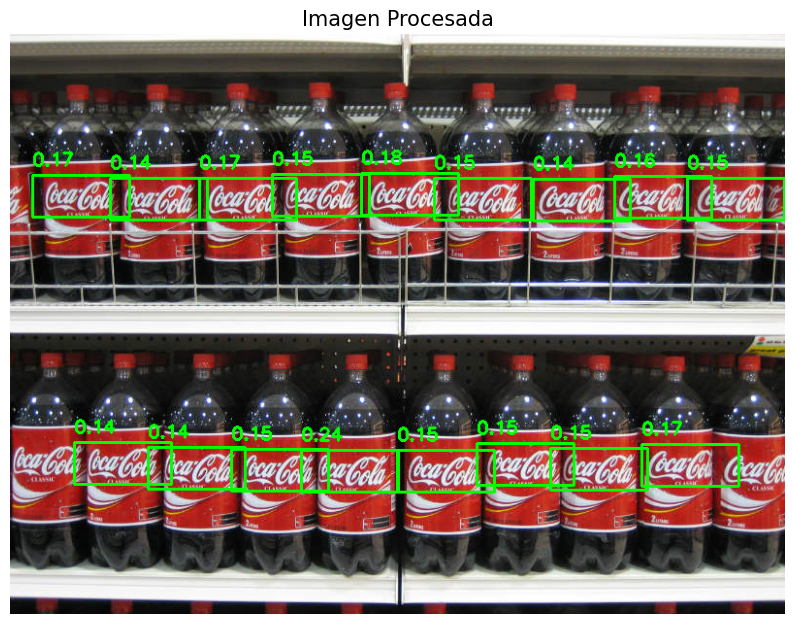

In [18]:
#Debajo de 0.14 empezamos a errar en las detecciones
threshold = 0.14

bounding_boxes = []  # Almacenamiento de las bounding boxes
confidence_scores = []  # almacenamiento de los matching scores

#Probamos con un escalamiento de 25 a 450%
for scale in np.linspace(0.25, 4.5, 20):  
    template_height, template_width = template.shape
    scaled_template = cv2.resize(template, (int(template_width * scale), int(template_height * scale)))
    scaled_height, scaled_width = scaled_template.shape
    
    processed_template = preprocess_image(scaled_template)
    
    if scaled_height > processed_image.shape[0] or scaled_width > processed_image.shape[1]:
        continue
   
    result = cv2.matchTemplate(processed_image, processed_template, cv2.TM_CCOEFF_NORMED)
    locations = np.where(result >= threshold)

    for pt, score in zip(zip(*locations[::-1]), result[locations]):
        x1, y1 = pt
        x2, y2 = x1 + scaled_width, y1 + scaled_height
        bounding_boxes.append((x1, y1, x2, y2))
        confidence_scores.append(score)

if bounding_boxes:
    print(f"Aplicando non max supresion para limitar la cantidad de rectangulos...")
    indices = non_max_suppression_fast(np.array(bounding_boxes), np.array(confidence_scores), overlap_thresh=0.3)
    j = 1
    for i in indices:        
        x1, y1, x2, y2 = bounding_boxes[i]
        #Dibuja bounding box
        cv2.rectangle(image_color, (x1, y1), (x2, y2), (0, 255, 0), 2)  
        print(f"Bounding box {j} en coordenadas: ({x1}, {y1}) a ({x2}, {y2})")
        #Escribe la confianza del boundix box
        text = f"{confidence_scores[j]:.2f}"
        cv2.putText(image_color, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.6, (0, 255, 0), 2)    
        j += 1
        
    print(f"Cantidad de logos detectados: {len(indices)}")
else:
    print(f"No logos detected.")

def show_image(image_with_rectangles):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_rectangles, cv2.COLOR_BGR2RGB))
    plt.title("Imagen Procesada", fontsize=15)
    plt.axis('off')
    plt.show()

show_image(image_color)
